## Libraries

In [54]:
import random
import matplotlib.pyplot as plt
import heapq
import time


## Cell 1: Drone State Definition

In [55]:
class DroneState:
    def __init__(self, x, y, fuel=10, lives=3, path_cost=0,
                 known_no_fly_zones=None, known_storm_map=None,
                 visible_map=None, time_step=0, path_history=None):
        self.x = x
        self.y = y
        self.fuel = fuel
        self.lives = lives
        self.path_cost = path_cost
        self.known_no_fly_zones = known_no_fly_zones if known_no_fly_zones is not None else set()
        self.known_storm_map = known_storm_map if known_storm_map is not None else set()
        self.visible_map = visible_map if visible_map is not None else {}
        self.time_step = time_step
        self.path_history = path_history if path_history is not None else [(x, y)]

    def __lt__(self, other):
        return self.path_cost < other.path_cost

    def position(self):
        return (self.x, self.y)

    def is_alive(self):
        return self.lives > 0 and self.fuel > 0

    def __eq__(self, other):
        return isinstance(other, DroneState) and (
            self.x, self.y, self.fuel, self.lives
        ) == (
            other.x, other.y, other.fuel, other.lives
        )

    def __hash__(self):
        return hash((self.x, self.y, self.fuel, self.lives))


## Cell 2: Successor Function

In [56]:
def get_successors(state, terrain, grid_size=15):
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1),
                  (-1, -1), (-1, 1), (1, -1), (1, 1)]
    successors = []

    for dx, dy in directions:
        nx, ny = state.x + dx, state.y + dy
        if 0 <= nx < grid_size and 0 <= ny < grid_size:
            cell = terrain.get((nx, ny), '.')

            # Determine cost/life impact
            new_lives = state.lives
            new_fuel = state.fuel - 1
            new_path_cost = state.path_cost + 1
            scan_blocked = False

            if new_fuel < 0:
                new_lives -= 1
                new_fuel = 0

            if cell == 'M':  # Mountain
                new_lives -= 1
                continue  # Cannot enter mountains

            if (nx, ny) in state.known_no_fly_zones:
                continue  # Mission failure if stepped in; avoid

            if cell == '~':  # Storm
                new_lives -= 1
                scan_blocked = True
                new_path_cost += random.randint(3, 9)

            if new_lives <= 0:
                continue

            # Create next state
            new_state = DroneState(
                x=nx,
                y=ny,
                fuel=new_fuel,
                lives=new_lives,
                path_cost=new_path_cost,
                known_no_fly_zones=set(state.known_no_fly_zones),
                known_storm_map=set(state.known_storm_map),
                visible_map=dict(state.visible_map),
                time_step=state.time_step + 1,
                path_history=state.path_history + [(nx, ny)]
            )

            successors.append(new_state)

    return successors


## Cell 3: Transition Model

In [57]:
def apply_transition(current_state, action, terrain):
    dx, dy = action
    nx, ny = current_state.x + dx, current_state.y + dy
    if not (0 <= nx < 15 and 0 <= ny < 15):
        return None

    cell = terrain.get((nx, ny), '.')
    new_fuel = current_state.fuel - 1
    new_lives = current_state.lives
    path_cost = current_state.path_cost + 1

    if new_fuel < 0:
        new_lives -= 1
        new_fuel = 0

    if cell == 'M':
        new_lives -= 1
        return None

    if cell == '~':
        new_lives -= 1
        path_cost += random.randint(3, 9)

    if new_lives <= 0:
        return None

    return DroneState(
        x=nx,
        y=ny,
        fuel=new_fuel,
        lives=new_lives,
        path_cost=path_cost,
        known_no_fly_zones=set(current_state.known_no_fly_zones),
        known_storm_map=set(current_state.known_storm_map),
        visible_map=dict(current_state.visible_map),
        time_step=current_state.time_step + 1,
        path_history=current_state.path_history + [(nx, ny)]
    )


## Cell 4: Cost Function

In [58]:
def cost_function(state, cell):
    base = 1
    if cell == '~':
        return base + random.randint(3, 9)
    if cell == 'M':
        return float('inf')  # Not enterable
    return base


## Cell 5: Goal Test

In [59]:
def is_goal_reached(state, goal_position):
    return state.position() == goal_position


# Task 3: Heuristic Design & Evaluation

## Cell 1: Drone Heuristic Functions

In [60]:
# h1: Pure Manhattan Distance to Goal
def heuristic_h1(drone_pos, goal_pos):
    return abs(drone_pos[0] - goal_pos[0]) + abs(drone_pos[1] - goal_pos[1])

# h2: Distance + Fuel Penalty
def heuristic_h2(drone_pos, goal_pos, fuel_left):
    distance = heuristic_h1(drone_pos, goal_pos)
    fuel_penalty = max(0, distance - fuel_left)
    return distance + 2 * fuel_penalty  # extra weight for being low on fuel

# h3: Distance + Life Risk (based on known storms/mountains nearby)
def heuristic_h3(drone_pos, goal_pos, lives, known_hazards):
    distance = heuristic_h1(drone_pos, goal_pos)
    hazard_penalty = sum(1 for dx in [-1,0,1] for dy in [-1,0,1]
                         if (drone_pos[0]+dx, drone_pos[1]+dy) in known_hazards and (dx,dy) != (0,0))
    return distance + (4 - lives) + hazard_penalty

# h4: Urgency-Aware Heuristic (distance + closeness to step limit)
def heuristic_h4(drone_pos, goal_pos, time_step):
    distance = heuristic_h1(drone_pos, goal_pos)
    urgency = max(0, (distance + time_step) - 30)
    return distance + urgency

# h5: Hybrid Risk-Aware Heuristic
def heuristic_h5(drone_pos, goal_pos, fuel, lives, known_hazards, no_fly_zones, time_step):
    distance = heuristic_h1(drone_pos, goal_pos)
    hazard_penalty = sum(1 for dx in [-1,0,1] for dy in [-1,0,1]
                         if (drone_pos[0]+dx, drone_pos[1]+dy) in known_hazards)
    fly_zone_penalty = sum(1 for dx in [-1,0,1] for dy in [-1,0,1]
                         if (drone_pos[0]+dx, drone_pos[1]+dy) in no_fly_zones)
    fuel_penalty = max(0, distance - fuel)
    urgency = max(0, (distance + time_step) - 30)
    return distance + 2*hazard_penalty + 3*fly_zone_penalty + 2*fuel_penalty + urgency


 ## Cell 2: A* Setup with Heuristic Selector

In [61]:
import time
import heapq

def drone_a_star(start_state, goal_pos, terrain, heuristic_id, grid_size=15):
    open_list = []
    heapq.heappush(open_list, (0, start_state))
    visited = set()
    came_from = {}
    expanded = 0
    start_time = time.time()

    while open_list:
        _, current = heapq.heappop(open_list)
        key = (current.x, current.y, current.lives, current.fuel)

        if key in visited:
            continue
        visited.add(key)
        expanded += 1

        if current.position() == goal_pos:
            path = reconstruct_path(came_from, current)
            duration = time.time() - start_time
            return {
                "success": True,
                "path": path,
                "path_cost": current.path_cost,
                "expanded_nodes": expanded,
                "time": duration
            }

        successors = get_successors(current, terrain, grid_size)
        for child in successors:
            if (child.x, child.y, child.lives, child.fuel) in visited:
                continue

            # Heuristic switch
            if heuristic_id == "h1":
                h = heuristic_h1(child.position(), goal_pos)
            elif heuristic_id == "h2":
                h = heuristic_h2(child.position(), goal_pos, child.fuel)
            elif heuristic_id == "h3":
                h = heuristic_h3(child.position(), goal_pos, child.lives, child.known_storm_map)
            elif heuristic_id == "h4":
                h = heuristic_h4(child.position(), goal_pos, child.time_step)
            else:  # h5
                h = heuristic_h5(child.position(), goal_pos, child.fuel, child.lives,
                                 child.known_storm_map, child.known_no_fly_zones, child.time_step)

            f = child.path_cost + h
            heapq.heappush(open_list, (f, child))
            came_from[child] = current

    return {"success": False, "path": [], "expanded_nodes": expanded, "path_cost": None, "time": time.time() - start_time}


## Cell 3: Benchmarking All Heuristics

In [62]:
def evaluate_all_heuristics(start_state, goal_pos, terrain):
    heuristics = ["h1", "h2", "h3", "h4", "h5"]
    results = {}

    for h in heuristics:
        print(f"Running A* with {h}...")
        result = drone_a_star(start_state, goal_pos, terrain, h)
        results[h] = result
        print(f" Success        : {result['success']}")
        print(f" Path Cost      : {result['path_cost']}")
        print(f" Nodes Expanded : {result['expanded_nodes']}")
        print(f" Time (s)       : {result['time']:.3f}")
        print("--------------------------------------------------")

    return results


## Plotting Function with User-Defined Goal

In [63]:
import matplotlib.pyplot as plt

def run_evaluation_with_goal_input(start_state, terrain):
    # --- Get goal from user ---
    try:
        gx = int(input("Enter goal X coordinate (0–14): "))
        gy = int(input("Enter goal Y coordinate (0–14): "))
        if not (0 <= gx < 15 and 0 <= gy < 15):
            print("Invalid goal coordinates.")
            return
    except ValueError:
        print("Invalid input.")
        return

    goal_pos = (gx, gy)
    results = evaluate_all_heuristics(start_state, goal_pos, terrain)

    heuristics = list(results.keys())
    path_costs = [results[h]['path_cost'] if results[h]['success'] else 0 for h in heuristics]
    expanded_nodes = [results[h]['expanded_nodes'] for h in heuristics]
    times = [results[h]['time'] for h in heuristics]

    # --- Plot 1: Path Cost ---
    plt.figure(figsize=(6, 4))
    plt.bar(heuristics, path_costs, color='lightblue')
    plt.title("Final Path Cost per Heuristic")
    plt.ylabel("Path Cost")
    plt.grid(axis='y')
    plt.show()

    # --- Plot 2: Expanded Nodes ---
    plt.figure(figsize=(6, 4))
    plt.bar(heuristics, expanded_nodes, color='lightgreen')
    plt.title("Expanded Nodes per Heuristic")
    plt.ylabel("Number of Expanded Nodes")
    plt.grid(axis='y')
    plt.show()

    # --- Plot 3: Execution Time ---
    plt.figure(figsize=(6, 4))
    plt.bar(heuristics, times, color='salmon')
    plt.title("Execution Time per Heuristic")
    plt.ylabel("Time (seconds)")
    plt.grid(axis='y')
    plt.show()


## Terrain Generator (Cell)

In [64]:
def generate_random_terrain(grid_size=15, goal_override=None):
    terrain = {}
    total_cells = grid_size * grid_size

    # Mountains
    num_mountains = int(0.2 * total_cells)
    for _ in range(num_mountains):
        while True:
            cell = (random.randint(0, grid_size - 1), random.randint(0, grid_size - 1))
            if cell not in terrain and cell != (0, 0):
                terrain[cell] = 'M'
                break

    # No-Fly Zones (X) — hidden from agent, but placed
    no_fly_zones = set()
    num_no_fly = int(0.2 * total_cells)
    while len(no_fly_zones) < num_no_fly:
        cell = (random.randint(0, grid_size - 1), random.randint(0, grid_size - 1))
        if cell not in terrain and cell != (0, 0):
            no_fly_zones.add(cell)

    # Storms (~)
    for _ in range(random.randint(1, 3)):
        while True:
            cell = (random.randint(0, grid_size - 1), random.randint(0, grid_size - 1))
            if cell not in terrain and cell != (0, 0):
                terrain[cell] = '~'
                break

    # Fuel stations (E) — not used by planner yet
    for _ in range(15):
        while True:
            cell = (random.randint(0, grid_size - 1), random.randint(0, grid_size - 1))
            if cell not in terrain and cell != (0, 0):
                terrain[cell] = 'E'
                break

    # Goal (G)
    if goal_override:
        goal_pos = goal_override
    else:
        while True:
            goal_pos = (random.randint(0, grid_size - 1), random.randint(0, grid_size - 1))
            if goal_pos != (0, 0) and goal_pos not in terrain:
                break
    terrain[goal_pos] = 'G'

    return terrain, no_fly_zones, goal_pos


In [65]:
def reconstruct_path(came_from, current):
    path = [current.position()]
    while current in came_from:
        current = came_from[current]
        path.append(current.position())
    path.reverse()
    return path


## Start State Initializer (Cell)

In [66]:
def init_start_state():
    return DroneState(
        x=0,
        y=0,
        fuel=10,
        lives=3,
        path_cost=0,
        known_no_fly_zones=set(),
        known_storm_map=set(),
        visible_map={},
        time_step=0,
        path_history=[(0, 0)]
    )


Running A* with h1...
 Success        : True
 Path Cost      : 5
 Nodes Expanded : 6
 Time (s)       : 0.000
--------------------------------------------------
Running A* with h2...
 Success        : True
 Path Cost      : 5
 Nodes Expanded : 6
 Time (s)       : 0.000
--------------------------------------------------
Running A* with h3...
 Success        : True
 Path Cost      : 5
 Nodes Expanded : 6
 Time (s)       : 0.000
--------------------------------------------------
Running A* with h4...
 Success        : True
 Path Cost      : 5
 Nodes Expanded : 6
 Time (s)       : 0.000
--------------------------------------------------
Running A* with h5...
 Success        : True
 Path Cost      : 5
 Nodes Expanded : 6
 Time (s)       : 0.000
--------------------------------------------------


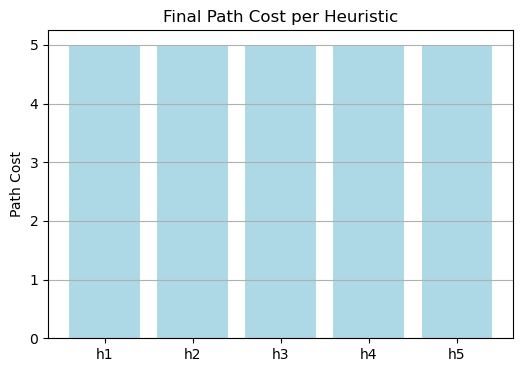

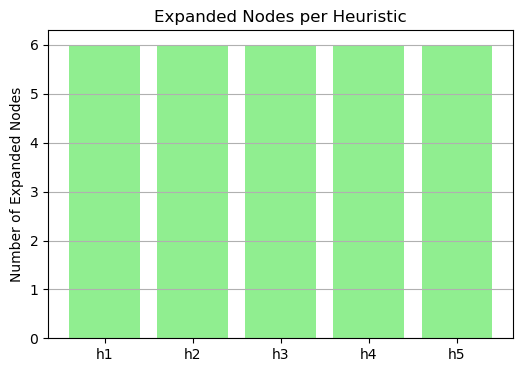

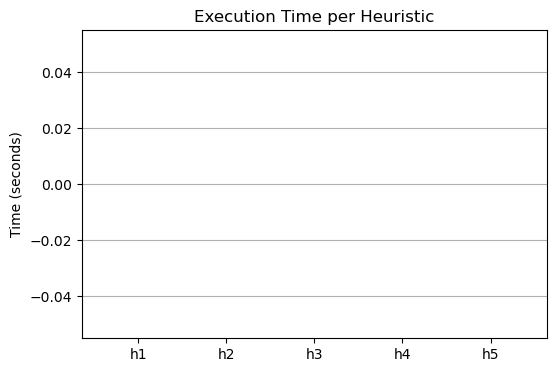

In [67]:
terrain, no_fly_zones, _ = generate_random_terrain()
start_state = init_start_state()
run_evaluation_with_goal_input(start_state, terrain)


# Task 4: Algorithm Implementations & Evaluations
We’ll implement:

UCS (Uniform Cost Search) – cost-optimal, no heuristic

Greedy Best-First Search – minimal f(n) = h(n)

A* Tree Search – f(n) = g(n) + h(n), no closed set

A* Graph Search – f(n) = g(n) + h(n), with closed set and dynamic replanning

## Cell 1: Uniform Cost Search (UCS)

In [68]:
def ucs_search(start_state, goal_pos, terrain, grid_size=15):
    open_list = []
    heapq.heappush(open_list, (0, start_state))
    visited = set()
    came_from = {}
    expanded = 0
    start_time = time.time()

    while open_list:
        cost, current = heapq.heappop(open_list)
        key = (current.x, current.y, current.lives, current.fuel)

        if key in visited:
            continue
        visited.add(key)
        expanded += 1

        if current.position() == goal_pos:
            path = reconstruct_path(came_from, current)
            return {
                "algorithm": "UCS",
                "success": True,
                "path": path,
                "path_cost": current.path_cost,
                "expanded_nodes": expanded,
                "time": time.time() - start_time
            }

        for child in get_successors(current, terrain, grid_size):
            heapq.heappush(open_list, (child.path_cost, child))
            came_from[child] = current

    return {
        "algorithm": "UCS",
        "success": False,
        "path": [],
        "expanded_nodes": expanded,
        "path_cost": None,
        "time": time.time() - start_time
    }


## Cell 2: Greedy Best-First Search

In [69]:
def greedy_search(start_state, goal_pos, terrain, heuristic_func, grid_size=15):
    open_list = []
    heapq.heappush(open_list, (0, start_state))
    visited = set()
    came_from = {}
    expanded = 0
    start_time = time.time()

    while open_list:
        _, current = heapq.heappop(open_list)
        key = (current.x, current.y, current.lives, current.fuel)

        if key in visited:
            continue
        visited.add(key)
        expanded += 1

        if current.position() == goal_pos:
            path = reconstruct_path(came_from, current)
            return {
                "algorithm": "Greedy",
                "success": True,
                "path": path,
                "path_cost": current.path_cost,
                "expanded_nodes": expanded,
                "time": time.time() - start_time
            }

        for child in get_successors(current, terrain, grid_size):
            if heuristic_func == heuristic_h2:
                h = heuristic_func(child.position(), goal_pos, child.fuel)
            elif heuristic_func == heuristic_h3:
                h = heuristic_func(child.position(), goal_pos, child.lives, child.known_storm_map)
            elif heuristic_func == heuristic_h5:
                h = heuristic_func(child.position(), goal_pos, child.fuel, child.lives,
                                   child.known_storm_map, child.known_no_fly_zones, child.time_step)
            else:
                h = heuristic_func(child.position(), goal_pos)

            heapq.heappush(open_list, (h, child))
            came_from[child] = current

    return {
        "algorithm": "Greedy",
        "success": False,
        "path": [],
        "expanded_nodes": expanded,
        "path_cost": None,
        "time": time.time() - start_time
    }


##  Cell 3: A* Tree Search (No Closed Set)

In [70]:
def a_star_tree_search(start_state, goal_pos, terrain, heuristic_func, grid_size=15):
    open_list = []
    heapq.heappush(open_list, (0, start_state))
    came_from = {}
    expanded = 0
    start_time = time.time()

    while open_list:
        _, current = heapq.heappop(open_list)
        expanded += 1

        if current.position() == goal_pos:
            path = reconstruct_path(came_from, current)
            return {
                "algorithm": "A* Tree",
                "success": True,
                "path": path,
                "path_cost": current.path_cost,
                "expanded_nodes": expanded,
                "time": time.time() - start_time
            }

        for child in get_successors(current, terrain, grid_size):
            if heuristic_func == heuristic_h2:
                h = heuristic_func(child.position(), goal_pos, child.fuel)
            elif heuristic_func == heuristic_h3:
                h = heuristic_func(child.position(), goal_pos, child.lives, child.known_storm_map)
            elif heuristic_func == heuristic_h5:
                h = heuristic_func(child.position(), goal_pos, child.fuel, child.lives,
                                   child.known_storm_map, child.known_no_fly_zones, child.time_step)
            else:
                h = heuristic_func(child.position(), goal_pos)

            f = child.path_cost + h
            heapq.heappush(open_list, (f, child))
            came_from[child] = current

    return {
        "algorithm": "A* Tree",
        "success": False,
        "path": [],
        "expanded_nodes": expanded,
        "path_cost": None,
        "time": time.time() - start_time
    }


## Cell 4: A* Graph Search (With Closed Set)
This version supports dynamic terrain updates by allowing a replanning hook every n steps

In [71]:
def a_star_graph_search(start_state, goal_pos, terrain, heuristic_func, grid_size=15, dynamic_every=10):
    open_list = []
    heapq.heappush(open_list, (0, start_state))
    came_from = {}
    visited = set()
    expanded = 0
    start_time = time.time()

    while open_list:
        _, current = heapq.heappop(open_list)
        key = (current.x, current.y, current.lives, current.fuel)

        if key in visited:
            continue
        visited.add(key)
        expanded += 1

        if current.position() == goal_pos:
            path = reconstruct_path(came_from, current)
            return {
                "algorithm": "A* Graph",
                "success": True,
                "path": path,
                "path_cost": current.path_cost,
                "expanded_nodes": expanded,
                "time": time.time() - start_time
            }

        if current.time_step > 0 and current.time_step % dynamic_every == 0:
            terrain, _, _ = generate_random_terrain(goal_override=goal_pos)

        for child in get_successors(current, terrain, grid_size):
            child_key = (child.x, child.y, child.lives, child.fuel)
            if child_key in visited:
                continue

            if heuristic_func == heuristic_h2:
                h = heuristic_func(child.position(), goal_pos, child.fuel)
            elif heuristic_func == heuristic_h3:
                h = heuristic_func(child.position(), goal_pos, child.lives, child.known_storm_map)
            elif heuristic_func == heuristic_h5:
                h = heuristic_func(child.position(), goal_pos, child.fuel, child.lives,
                                   child.known_storm_map, child.known_no_fly_zones, child.time_step)
            else:
                h = heuristic_func(child.position(), goal_pos)

            f = child.path_cost + h
            heapq.heappush(open_list, (f, child))
            came_from[child] = current

    return {
        "algorithm": "A* Graph",
        "success": False,
        "path": [],
        "expanded_nodes": expanded,
        "path_cost": None,
        "time": time.time() - start_time
    }


## Cell 5: Run All Algorithms and Compare

In [72]:
def run_all_algorithms(start_state, goal_pos, terrain):
    results = {}

    results['UCS'] = ucs_search(start_state, goal_pos, terrain)
    results['Greedy-h1'] = greedy_search(start_state, goal_pos, terrain, heuristic_func=heuristic_h1)
    results['A*_Tree-h2'] = a_star_tree_search(start_state, goal_pos, terrain, heuristic_func=heuristic_h2)
    results['A*_Graph-h5'] = a_star_graph_search(start_state, goal_pos, terrain, heuristic_func=heuristic_h5)

    for key, res in results.items():
        print(f"\nAlgorithm: {res['algorithm']}")
        print(f" Success        : {res['success']}")
        print(f" Path Cost      : {res['path_cost']}")
        print(f" Nodes Expanded : {res['expanded_nodes']}")
        print(f" Time (s)       : {res['time']:.3f}")

    return results


In [73]:
def run_algorithms_with_goal_input(start_state, terrain):
    try:
        gx = int(input("Enter goal X coordinate (0–14): "))
        gy = int(input("Enter goal Y coordinate (0–14): "))
        if not (0 <= gx < 15 and 0 <= gy < 15):
            print("Invalid goal coordinates.")
            return
    except ValueError:
        print("Invalid input.")
        return

    goal_pos = (gx, gy)
    results = run_all_algorithms(start_state, goal_pos, terrain)

    labels = list(results.keys())
    path_costs = [results[k]['path_cost'] if results[k]['success'] else 0 for k in labels]
    expanded_nodes = [results[k]['expanded_nodes'] for k in labels]
    times = [results[k]['time'] for k in labels]

    # --- Plot 1: Path Cost ---
    plt.figure(figsize=(6, 4))
    plt.bar(labels, path_costs, color='lightblue')
    plt.title("Path Cost per Algorithm")
    plt.ylabel("Path Cost")
    plt.grid(axis='y')
    plt.xticks(rotation=15)
    plt.show()

    # --- Plot 2: Expanded Nodes ---
    plt.figure(figsize=(6, 4))
    plt.bar(labels, expanded_nodes, color='lightgreen')
    plt.title("Expanded Nodes per Algorithm")
    plt.ylabel("Nodes Expanded")
    plt.grid(axis='y')
    plt.xticks(rotation=15)
    plt.show()

    # --- Plot 3: Execution Time ---
    plt.figure(figsize=(6, 4))
    plt.bar(labels, times, color='salmon')
    plt.title("Execution Time per Algorithm")
    plt.ylabel("Time (seconds)")
    plt.grid(axis='y')
    plt.xticks(rotation=15)
    plt.show()



Algorithm: UCS
 Success        : True
 Path Cost      : 5
 Nodes Expanded : 55
 Time (s)       : 0.000

Algorithm: Greedy
 Success        : True
 Path Cost      : 5
 Nodes Expanded : 6
 Time (s)       : 0.000

Algorithm: A* Tree
 Success        : True
 Path Cost      : 5
 Nodes Expanded : 6
 Time (s)       : 0.000

Algorithm: A* Graph
 Success        : True
 Path Cost      : 5
 Nodes Expanded : 6
 Time (s)       : 0.000


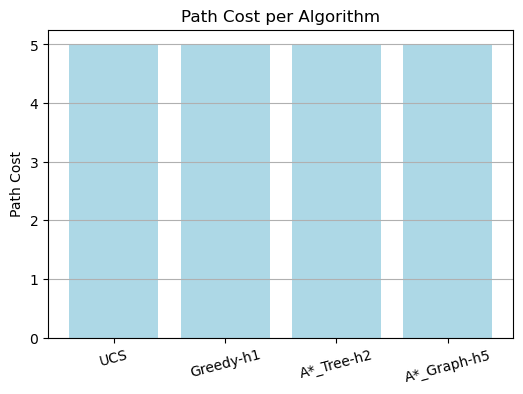

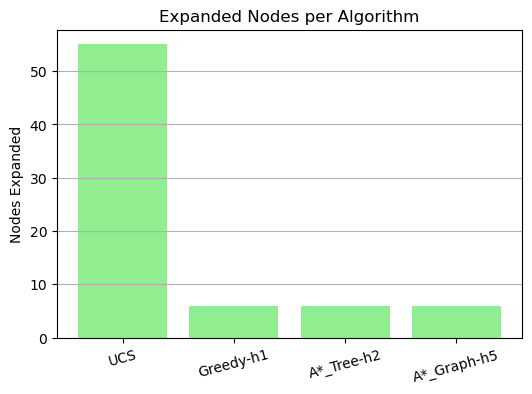

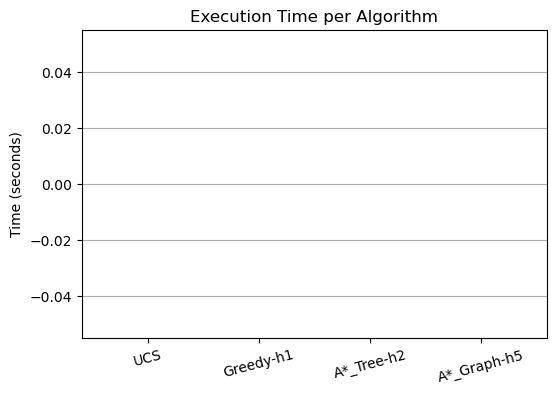

In [74]:
terrain, no_fly_zones, _ = generate_random_terrain()
start_state = init_start_state()
run_algorithms_with_goal_input(start_state, terrain)

# Task 5: Dynamic Goal Discovery & Replanning
## Behavior Summary
    Phase	Description
    Initial	Drone explores blindly — goal is not visible
    Detection	If the goal enters perception radius = 2, drone “sees” it
    Replanning	Drone immediately replans with A* toward the known goal

## Cell 1: Visibility Checker

In [75]:
def is_goal_visible(drone_pos, goal_pos, radius=2):
    dx = abs(drone_pos[0] - goal_pos[0])
    dy = abs(drone_pos[1] - goal_pos[1])
    return dx <= radius and dy <= radius


## Cell 2: Dynamic Search with Goal Discovery

In [76]:
def dynamic_goal_search(start_state, terrain, goal_pos, heuristic_func, grid_size=15):
    open_list = []
    heapq.heappush(open_list, (0, start_state))
    came_from = {}
    visited = set()
    expanded = 0
    start_time = time.time()
    goal_discovered = False

    while open_list:
        _, current = heapq.heappop(open_list)
        key = (current.x, current.y, current.lives, current.fuel)

        if key in visited:
            continue
        visited.add(key)
        expanded += 1

        # Check if drone has discovered the goal
        if not goal_discovered and is_goal_visible(current.position(), goal_pos):
            print(f"[Step {current.time_step}] 🚨 Goal discovered at {goal_pos}!")
            goal_discovered = True
            # Reset open list and visited to start fresh replanning
            open_list = []
            visited = set()
            heapq.heappush(open_list, (0, current))
            came_from = {}
            continue

        # Once goal is discovered and reached
        if goal_discovered and current.position() == goal_pos:
            path = reconstruct_path(came_from, current)
            return {
                "algorithm": "Dynamic A*",
                "success": True,
                "path": path,
                "path_cost": current.path_cost,
                "expanded_nodes": expanded,
                "time": time.time() - start_time
            }

        for child in get_successors(current, terrain, grid_size):
            child_key = (child.x, child.y, child.lives, child.fuel)
            if child_key in visited:
                continue

            # Use full heuristic only once goal is known
            if goal_discovered:
                if heuristic_func == heuristic_h2:
                    h = heuristic_func(child.position(), goal_pos, child.fuel)
                elif heuristic_func == heuristic_h3:
                    h = heuristic_func(child.position(), goal_pos, child.lives, child.known_storm_map)
                elif heuristic_func == heuristic_h5:
                    h = heuristic_func(child.position(), goal_pos, child.fuel, child.lives,
                                       child.known_storm_map, child.known_no_fly_zones, child.time_step)
                else:
                    h = heuristic_func(child.position(), goal_pos)
            else:
                h = 0  # No goal known yet — default to low priority exploration

            f = child.path_cost + h
            heapq.heappush(open_list, (f, child))
            came_from[child] = current

    return {
        "algorithm": "Dynamic A*",
        "success": False,
        "path": [],
        "expanded_nodes": expanded,
        "path_cost": None,
        "time": time.time() - start_time
    }


## Cell 3: Run and Print Result

In [77]:
def run_dynamic_goal_demo():
    terrain, _, goal_pos = generate_random_terrain()
    start_state = init_start_state()
    result = dynamic_goal_search(start_state, terrain, goal_pos, heuristic_func=heuristic_h5)

    print("\n=== Dynamic Goal Search Summary ===")
    print(f" Algorithm       : {result['algorithm']}")
    print(f" Goal Position   : {goal_pos}")
    print(f" Success         : {result['success']}")
    print(f" Path Cost       : {result['path_cost']}")
    print(f" Nodes Expanded  : {result['expanded_nodes']}")
    print(f" Execution Time  : {result['time']:.3f} seconds")


In [78]:
run_dynamic_goal_demo()

[Step 4] 🚨 Goal discovered at (6, 4)!

=== Dynamic Goal Search Summary ===
 Algorithm       : Dynamic A*
 Goal Position   : (6, 4)
 Success         : True
 Path Cost       : 7
 Nodes Expanded  : 27
 Execution Time  : 0.000 seconds


# Task 6: Logging & Live Animation for Drone Navigation

## Part 1: Logging Framework

In [79]:
class DroneLogger:
    def __init__(self):
        self.logs = []
        self.replans = []
        self.total_nodes_expanded = 0

    def log_step(self, step, position, action, fuel, lives):
        self.logs.append({
            "step": step,
            "pos": position,
            "action": action,
            "fuel": fuel,
            "lives": lives
        })

    def log_replan(self, step):
        self.replans.append(step)

    def set_total_expanded(self, count):
        self.total_nodes_expanded = count

    def print_summary(self):
        print("\n==== LOG SUMMARY ====")
        for log in self.logs:
            print(f"Step {log['step']:2}: Pos={log['pos']} | Action={log['action']:<5} | Fuel={log['fuel']} | Lives={log['lives']}")
        print(f"Replans triggered at: {self.replans}")
        print(f"Total nodes expanded: {self.total_nodes_expanded}")


## Part 2: Live Animation Function

In [80]:
import numpy as np


def animate_drone_path(path, terrain, goal_pos, logger, delay=0.5, grid_size=15, perception_radius=2):
    from IPython.display import clear_output

    for i, position in enumerate(path):
        clear_output(wait=True)
        plt.figure(figsize=(7, 7))
        ax = plt.gca()
        ax.set_xlim(0, grid_size)
        ax.set_ylim(0, grid_size)
        ax.set_xticks(np.arange(0, grid_size + 1, 1))
        ax.set_yticks(np.arange(0, grid_size + 1, 1))
        ax.grid(True)
        ax.set_aspect('equal')
        ax.invert_yaxis()

        # Draw terrain
        for (x, y), val in terrain.items():
            if val == 'M':
                plt.plot(y + 0.5, x + 0.5, 's', color='brown', markersize=20)
            elif val == '~':
                plt.plot(y + 0.5, x + 0.5, '*', color='purple', markersize=20)
            elif val == 'E':
                plt.plot(y + 0.5, x + 0.5, '^', color='orange', markersize=20)

        # Draw goal
        plt.plot(goal_pos[1] + 0.5, goal_pos[0] + 0.5, 'yd', markersize=20, label='Goal')

        # Draw perception radius
        px, py = position
        for dx in range(-perception_radius, perception_radius + 1):
            for dy in range(-perception_radius, perception_radius + 1):
                nx, ny = px + dx, py + dy
                if 0 <= nx < grid_size and 0 <= ny < grid_size:
                    plt.plot(ny + 0.5, nx + 0.5, 'o', color='lightgrey', markersize=10, alpha=0.2)

        # Draw path trail
        for step in path[:i + 1]:
            plt.plot(step[1] + 0.5, step[0] + 0.5, 'b.', markersize=10)

        # Draw drone
        plt.plot(py + 0.5, px + 0.5, 'go', markersize=20, label='Drone')

        if i == 0:
            plt.legend(loc='upper right')

        plt.title(f"Step {i+1}/{len(path)} | Drone at {position}")
        plt.show()
        time.sleep(delay)

    print("\n✅ MISSION ACCOMPLISHED")
    print(f"Lives: {logger.logs[-1]['lives']} | Fuel: {logger.logs[-1]['fuel']} | Nodes Expanded: {logger.total_nodes_expanded}")


## Part 3: Heuristic Heatmap Visualizer

In [81]:
def plot_heuristic_maps(f_values, g_values, h_values, grid_size=15):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    maps = [('f(n)', f_values), ('g(n)', g_values), ('h(n)', h_values)]
    for ax, (label, value_map) in zip(axes, maps):
        heatmap = np.zeros((grid_size, grid_size))
        for (x, y), val in value_map.items():
            heatmap[x][y] = val
        cax = ax.imshow(heatmap, cmap='viridis', interpolation='nearest')
        ax.set_title(label)
        ax.set_xticks(range(grid_size))
        ax.set_yticks(range(grid_size))
        fig.colorbar(cax, ax=ax)

    plt.suptitle("Heuristic Visualizations: f(n), g(n), h(n)")
    plt.show()


## drone_a_star() with Logging & Heuristic Tracking Integrated

In [82]:
def drone_a_star_with_logging(start_state, goal_pos, terrain, heuristic_func, logger=None, grid_size=15):
    open_list = []
    heapq.heappush(open_list, (0, start_state))
    came_from = {}
    visited = set()
    expanded = 0
    start_time = time.time()

    g_values = {}
    h_values = {}
    f_values = {}

    while open_list:
        _, current = heapq.heappop(open_list)
        key = (current.x, current.y, current.lives, current.fuel)

        if key in visited:
            continue
        visited.add(key)
        expanded += 1

        pos = current.position()
        g_values[pos] = current.path_cost

        # Logging step
        if logger:
            logger.log_step(current.time_step, pos, action="move", fuel=current.fuel, lives=current.lives)

        if pos == goal_pos:
            path = reconstruct_path(came_from, current)
            if logger:
                logger.set_total_expanded(expanded)
            return {
                "success": True,
                "path": path,
                "path_cost": current.path_cost,
                "expanded_nodes": expanded,
                "time": time.time() - start_time,
                "g_values": g_values,
                "h_values": h_values,
                "f_values": f_values,
                "logger": logger
            }

        for child in get_successors(current, terrain, grid_size):
            child_key = (child.x, child.y, child.lives, child.fuel)
            if child_key in visited:
                continue

            # Compute heuristic
            if heuristic_func == heuristic_h2:
                h = heuristic_func(child.position(), goal_pos, child.fuel)
            elif heuristic_func == heuristic_h3:
                h = heuristic_func(child.position(), goal_pos, child.lives, child.known_storm_map)
            elif heuristic_func == heuristic_h5:
                h = heuristic_func(child.position(), goal_pos, child.fuel, child.lives,
                                   child.known_storm_map, child.known_no_fly_zones, child.time_step)
            else:
                h = heuristic_func(child.position(), goal_pos)

            g = child.path_cost
            f = g + h

            # Store values for heatmap
            g_values[child.position()] = g
            h_values[child.position()] = h
            f_values[child.position()] = f

            heapq.heappush(open_list, (f, child))
            came_from[child] = current

    return {
        "success": False,
        "path": [],
        "path_cost": None,
        "expanded_nodes": expanded,
        "time": time.time() - start_time,
        "g_values": g_values,
        "h_values": h_values,
        "f_values": f_values,
        "logger": logger
    }


## Demo Runner With Animation, Logging, and Heatmap

In [83]:
def run_drone_demo_with_logging_and_visuals():
    # Setup
    terrain, _, goal_pos = generate_random_terrain()
    start_state = init_start_state()
    logger = DroneLogger()

    print(f"🎯 Random Goal Location: {goal_pos}")
    result = drone_a_star_with_logging(
        start_state=start_state,
        goal_pos=goal_pos,
        terrain=terrain,
        heuristic_func=heuristic_h5,
        logger=logger
    )

    # Logging Summary
    logger.print_summary()

    # Animation
    if result["success"]:
        animate_drone_path(
            path=result["path"],
            terrain=terrain,
            goal_pos=goal_pos,
            logger=logger,
            delay=0.4
        )
    else:
        print("❌ Mission failed — no valid path.")

    # Heatmap
    plot_heuristic_maps(result["f_values"], result["g_values"], result["h_values"])



✅ MISSION ACCOMPLISHED
Lives: 2 | Fuel: 0 | Nodes Expanded: 12


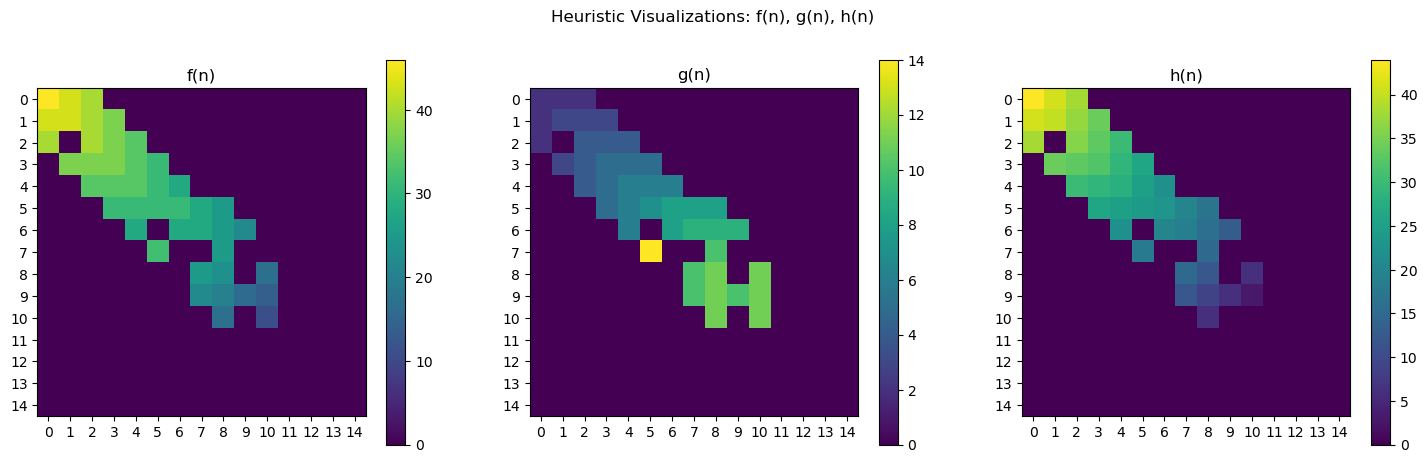

In [84]:
run_drone_demo_with_logging_and_visuals()


## Demo Runner with User Goal + Full Visualization

In [85]:
def run_full_drone_visualization_with_input():
    # --- Get goal from user ---
    try:
        gx = int(input("Enter goal X coordinate (0–14): "))
        gy = int(input("Enter goal Y coordinate (0–14): "))
        if not (0 <= gx < 15 and 0 <= gy < 15):
            print("Invalid goal coordinates.")
            return
    except ValueError:
        print("Invalid input.")
        return

    goal_pos = (gx, gy)
    print(f"\n🎯 Using Goal Position: {goal_pos}")

    # --- Prepare environment ---
    terrain, _, _ = generate_random_terrain(goal_override=goal_pos)
    start_state = init_start_state()
    logger = DroneLogger()

    # --- Run A* with logging + heuristic tracking ---
    result = drone_a_star_with_logging(
        start_state=start_state,
        goal_pos=goal_pos,
        terrain=terrain,
        heuristic_func=heuristic_h5,
        logger=logger
    )

    # --- Step-by-step animation ---
    if result["success"]:
        animate_drone_path(
            path=result["path"],
            terrain=terrain,
            goal_pos=goal_pos,
            logger=logger,
            delay=0.4
        )
    else:
        print("❌ MISSION FAILED: No path found.")

    # --- Log Summary ---
    logger.print_summary()

    # --- Heuristic Visualization ---
    print("\n📊 Generating heuristic maps...")
    plot_heuristic_maps(result["f_values"], result["g_values"], result["h_values"])



✅ MISSION ACCOMPLISHED
Lives: 3 | Fuel: 5 | Nodes Expanded: 6

==== LOG SUMMARY ====
Step  0: Pos=(0, 0) | Action=move  | Fuel=10 | Lives=3
Step  1: Pos=(1, 1) | Action=move  | Fuel=9 | Lives=3
Step  2: Pos=(2, 2) | Action=move  | Fuel=8 | Lives=3
Step  3: Pos=(3, 3) | Action=move  | Fuel=7 | Lives=3
Step  4: Pos=(4, 4) | Action=move  | Fuel=6 | Lives=3
Step  5: Pos=(5, 5) | Action=move  | Fuel=5 | Lives=3
Replans triggered at: []
Total nodes expanded: 6

📊 Generating heuristic maps...


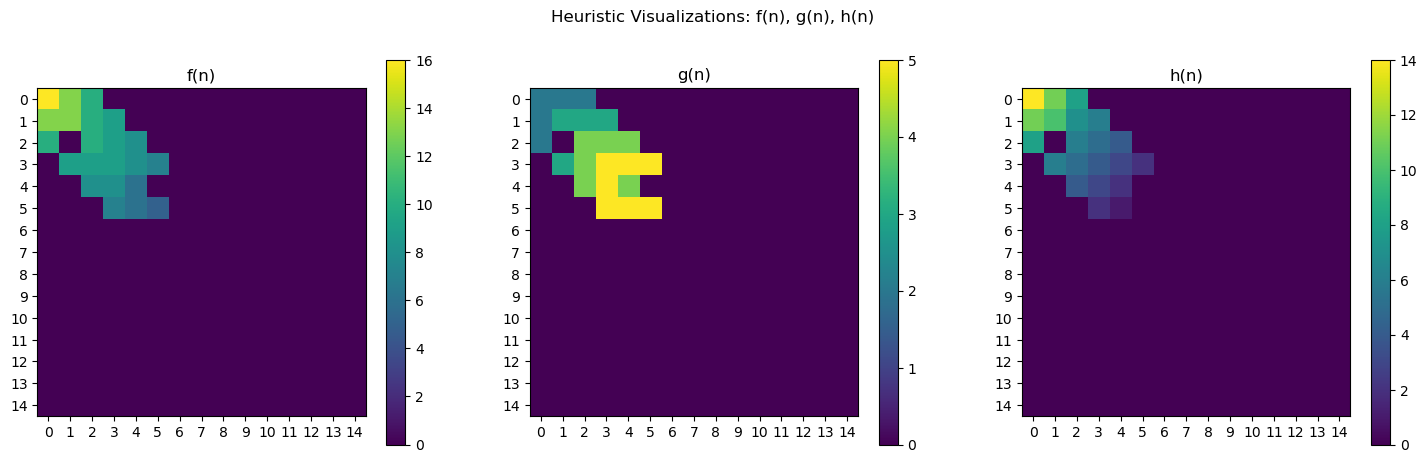

In [86]:
run_full_drone_visualization_with_input()


## Full Integration: User Input + Terrain Reshuffling + Full Visuals

In [87]:
def run_full_drone_visualization_with_input_and_reshuffling():
    try:
        gx = int(input("Enter goal X coordinate (0–14): "))
        gy = int(input("Enter goal Y coordinate (0–14): "))
        if not (0 <= gx < 15 and 0 <= gy < 15):
            print("Invalid goal coordinates.")
            return
    except ValueError:
        print("Invalid input.")
        return

    goal_pos = (gx, gy)
    print(f"\n🎯 Goal set at: {goal_pos}")

    terrain, _, _ = generate_random_terrain(goal_override=goal_pos)
    start_state = init_start_state()
    logger = DroneLogger()

    open_list = []
    heapq.heappush(open_list, (0, start_state))
    came_from = {}
    visited = set()
    expanded = 0
    g_values = {}
    h_values = {}
    f_values = {}
    step_count = 0

    while open_list:
        _, current = heapq.heappop(open_list)
        key = (current.x, current.y, current.lives, current.fuel)

        if key in visited:
            continue
        visited.add(key)
        expanded += 1
        pos = current.position()
        g_values[pos] = current.path_cost

        logger.log_step(current.time_step, pos, action="move", fuel=current.fuel, lives=current.lives)

        if pos == goal_pos:
            path = reconstruct_path(came_from, current)
            logger.set_total_expanded(expanded)

            animate_drone_path(path, terrain, goal_pos, logger, delay=0.4)
            logger.print_summary()
            plot_heuristic_maps(f_values, g_values, h_values)
            return

        # Reshuffle terrain every 10 steps
        if current.time_step > 0 and current.time_step % 10 == 0:
            terrain, _, _ = generate_random_terrain(goal_override=goal_pos)
            logger.log_replan(current.time_step)
            visited = set()  # allow replanning to revisit

        for child in get_successors(current, terrain):
            child_key = (child.x, child.y, child.lives, child.fuel)
            if child_key in visited:
                continue

            # Compute heuristic
            if heuristic_h5 == heuristic_h2:
                h = heuristic_h2(child.position(), goal_pos, child.fuel)
            elif heuristic_h5 == heuristic_h3:
                h = heuristic_h3(child.position(), goal_pos, child.lives, child.known_storm_map)
            else:
                h = heuristic_h5(child.position(), goal_pos, child.fuel, child.lives,
                                 child.known_storm_map, child.known_no_fly_zones, child.time_step)

            g = child.path_cost
            f = g + h

            g_values[child.position()] = g
            h_values[child.position()] = h
            f_values[child.position()] = f

            heapq.heappush(open_list, (f, child))
            came_from[child] = current

    print("❌ MISSION FAILED: No path found.")



✅ MISSION ACCOMPLISHED
Lives: 3 | Fuel: 5 | Nodes Expanded: 6

==== LOG SUMMARY ====
Step  0: Pos=(0, 0) | Action=move  | Fuel=10 | Lives=3
Step  1: Pos=(1, 1) | Action=move  | Fuel=9 | Lives=3
Step  2: Pos=(2, 2) | Action=move  | Fuel=8 | Lives=3
Step  3: Pos=(3, 3) | Action=move  | Fuel=7 | Lives=3
Step  4: Pos=(4, 4) | Action=move  | Fuel=6 | Lives=3
Step  5: Pos=(5, 5) | Action=move  | Fuel=5 | Lives=3
Replans triggered at: []
Total nodes expanded: 6


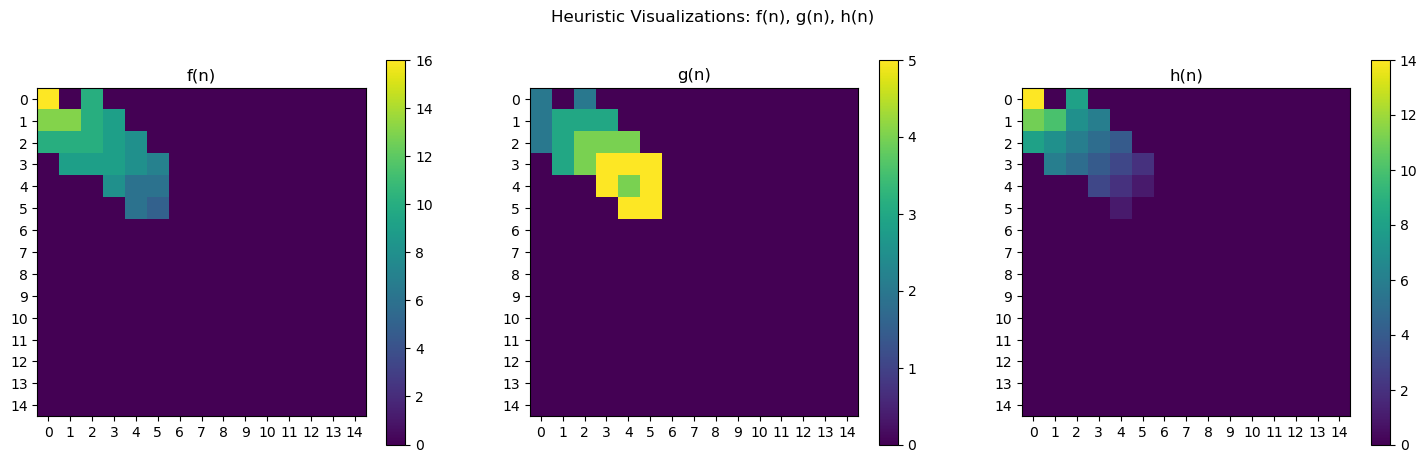

In [88]:
run_full_drone_visualization_with_input_and_reshuffling()


## Final Function: plot_annotated_drone_path_map()

In [91]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

def plot_annotated_drone_path_map(path, terrain, goal_pos, grid_size=15):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_xticks(range(grid_size))
    ax.set_yticks(range(grid_size))
    ax.grid(True)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.set_facecolor("black")

    # Draw terrain features
    for (x, y), val in terrain.items():
        if val == 'M':
            ax.plot(y + 0.5, x + 0.5, 's', color='salmon', markersize=10)
        elif val == '~':
            ax.plot(y + 0.5, x + 0.5, '*', color='red', markersize=10)
        elif val == 'E':
            ax.plot(y + 0.5, x + 0.5, '^', color='blue', markersize=10)

    # Plot start and goal
    sx, sy = path[0]
    gx, gy = goal_pos
    ax.plot(sy + 0.5, sx + 0.5, 'go', markersize=10, label='Start')
    ax.plot(gy + 0.5, gx + 0.5, 'r*', markersize=12, label='Goal')

    # Generate colormap for path steps
    norm = plt.Normalize(0, len(path))
    colors = cm.viridis(norm(range(len(path))))

    # Draw path with color gradient and step numbers
    for i in range(1, len(path)):
        x0, y0 = path[i-1]
        x1, y1 = path[i]
        ax.plot([y0 + 0.5, y1 + 0.5], [x0 + 0.5, x1 + 0.5], color=colors[i], linewidth=2)

        # Label with step number
        ax.text(y1 + 0.3, x1 + 0.3, str(i), fontsize=7, color='white')

    ax.legend(loc='lower center')
    plt.title("Drone Path Map with Step Numbers and Color-Coded Trail")
    plt.show()


In [93]:
def drone_path_plot_from_user_goal():
    # Step 1: Get user goal
    try:
        gx = int(input("Enter goal X coordinate (0–14): "))
        gy = int(input("Enter goal Y coordinate (0–14): "))
        if not (0 <= gx < 15 and 0 <= gy < 15):
            print("Invalid goal coordinates.")
            return
    except ValueError:
        print("Invalid input.")
        return

    goal_pos = (gx, gy)
    print(f"🎯 Goal set at: {goal_pos}")

    # Step 2: Setup and solve
    terrain, _, _ = generate_random_terrain(goal_override=goal_pos)
    start_state = init_start_state()

    result = drone_a_star_with_logging(
        start_state=start_state,
        goal_pos=goal_pos,
        terrain=terrain,
        heuristic_func=heuristic_h5,
        logger=None
    )

    if not result["success"]:
        print("❌ No path found.")
        return

    # Step 3: Plot with annotation
    plot_annotated_drone_path_map(
        path=result["path"],
        terrain=terrain,
        goal_pos=goal_pos
    )


🎯 Goal set at: (10, 4)


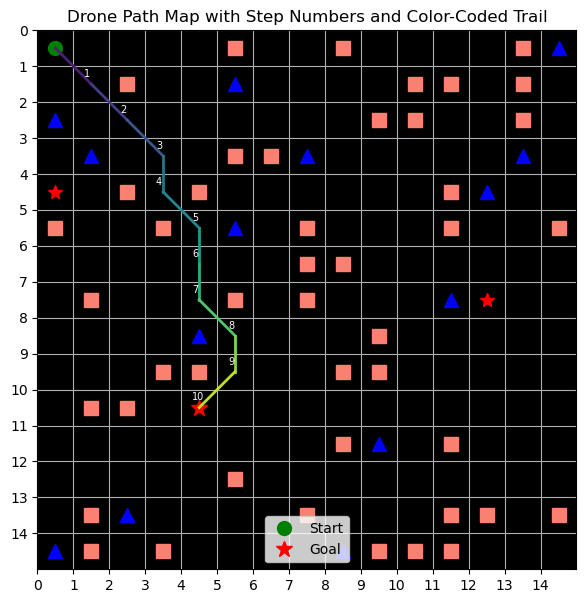

In [95]:
drone_path_plot_from_user_goal()
